# Classification Trees and Forests -- Sales Level Prediction

In this notebook, we will predict the sales level (high or low) of car seats. 

## Review of Decision Tree

### Data

Let's first load the dataset from a csv file, which contains sales volumes of a car seat product at various retail locations, as well as factors that potentially affect sales. 

In [1]:
import pandas as pd

carseats = pd.read_csv("https://raw.githubusercontent.com/zhouy185/BUS_O712/refs/heads/main/Data/carseats.csv")

In [2]:
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Consider **7 thousand** units as the benchmark sales volume. 
* We label any sales volume as **high** if it exceeds 7, and low if it is below 7.


We will:
* **create** a new column to indicate if a retail location's sales volume is **high**.
* drop the *Sales* column, as we will predict the sales level (high or low) instead of the sales number.

In [6]:
carseats['High_Sales'] = (carseats['Sales']>=7).astype(int)
carseats.drop('Sales',axis=1,inplace=True)
carseats.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High_Sales
0,138,73,11,276,120,Bad,42,17,Yes,Yes,1
1,111,48,16,260,83,Good,65,10,Yes,Yes,1
2,113,35,10,269,80,Medium,59,12,Yes,Yes,1
3,117,100,4,466,97,Medium,55,14,Yes,Yes,1
4,141,64,3,340,128,Bad,38,13,Yes,No,0


### Preprocessing (one-hot encoding)

Let's perform one-hot encoding on the categorical varaible.

In [7]:
carseats_encoded = pd.get_dummies(carseats,columns=['ShelveLoc','Urban','US'], 
                                  drop_first=True, dtype=int)
carseats_encoded.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,High_Sales,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,1,0,0,1,1
1,111,48,16,260,83,65,10,1,1,0,1,1
2,113,35,10,269,80,59,12,1,0,1,1,1
3,117,100,4,466,97,55,14,1,0,1,1,1
4,141,64,3,340,128,38,13,0,0,0,1,0


Split the dataset into features and target.

In [8]:
X = carseats_encoded.drop('High_Sales',axis=1)

y = carseats_encoded['High_Sales']

Train-test split:

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=28,stratify=y)

## Decision tree model

Note that it is not necessary to scale the features for tree-based methods
* they are not distance-based methods 
* they do not use gradient-based methods

When constructing the tree, we may specify the hyperparameters to keyword arguments. If not specified, default values will be used.

In [10]:
from sklearn.tree import DecisionTreeClassifier as DTC
 
tree = DTC(
    criterion = 'gini',
    max_depth = 4,
    min_samples_split = 5, 
    min_samples_leaf = 3, 
    max_features = 'log2',
    ccp_alpha = 0.01,
    random_state = 18
)

See the handout for list of the hyperparameters for building a decision tree.

We can fit the model to the training data by the `.fit()` function.

In [11]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=4, max_features='log2',
                       min_samples_leaf=3, min_samples_split=5,
                       random_state=18)

Let's make predictions on the test set and get the classification report and the AUC score.

In [18]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

cr = classification_report(y_test, y_pred)

print(cr)

auc = roc_auc_score(y_test,y_prob[:,1])

print(f'AUC={auc}')

              precision    recall  f1-score   support

           0       0.61      0.68      0.64        37
           1       0.69      0.63      0.66        43

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80

AUC=0.6527341294783156


### Exercise: Cross-validation

Perform a 10-fold cross-validation. 

In [24]:

# CV strategy 

# Get the scores for each train-test split in CV


The attribute `feature_importances_` of the trained model shows the importance of the features.

In [22]:
pd.DataFrame({'features': X.columns,'importance':tree.feature_importances_})

,features,importance
0,CompPrice,0.000000
1,Income,0.204441
2,Advertising,0.212568
3,Population,0.000000
4,Price,0.375259
5,Age,0.000000
6,Education,0.000000
7,ShelveLoc_Good,0.205654
8,ShelveLoc_Medium,0.002077
9,Urban_Yes,0.000000


## Plot the fitted tree

We may plot the fitted tree using the `plot_tree()` function.

The tree shows how we splitted each node (if not a leaf node), along with other information.

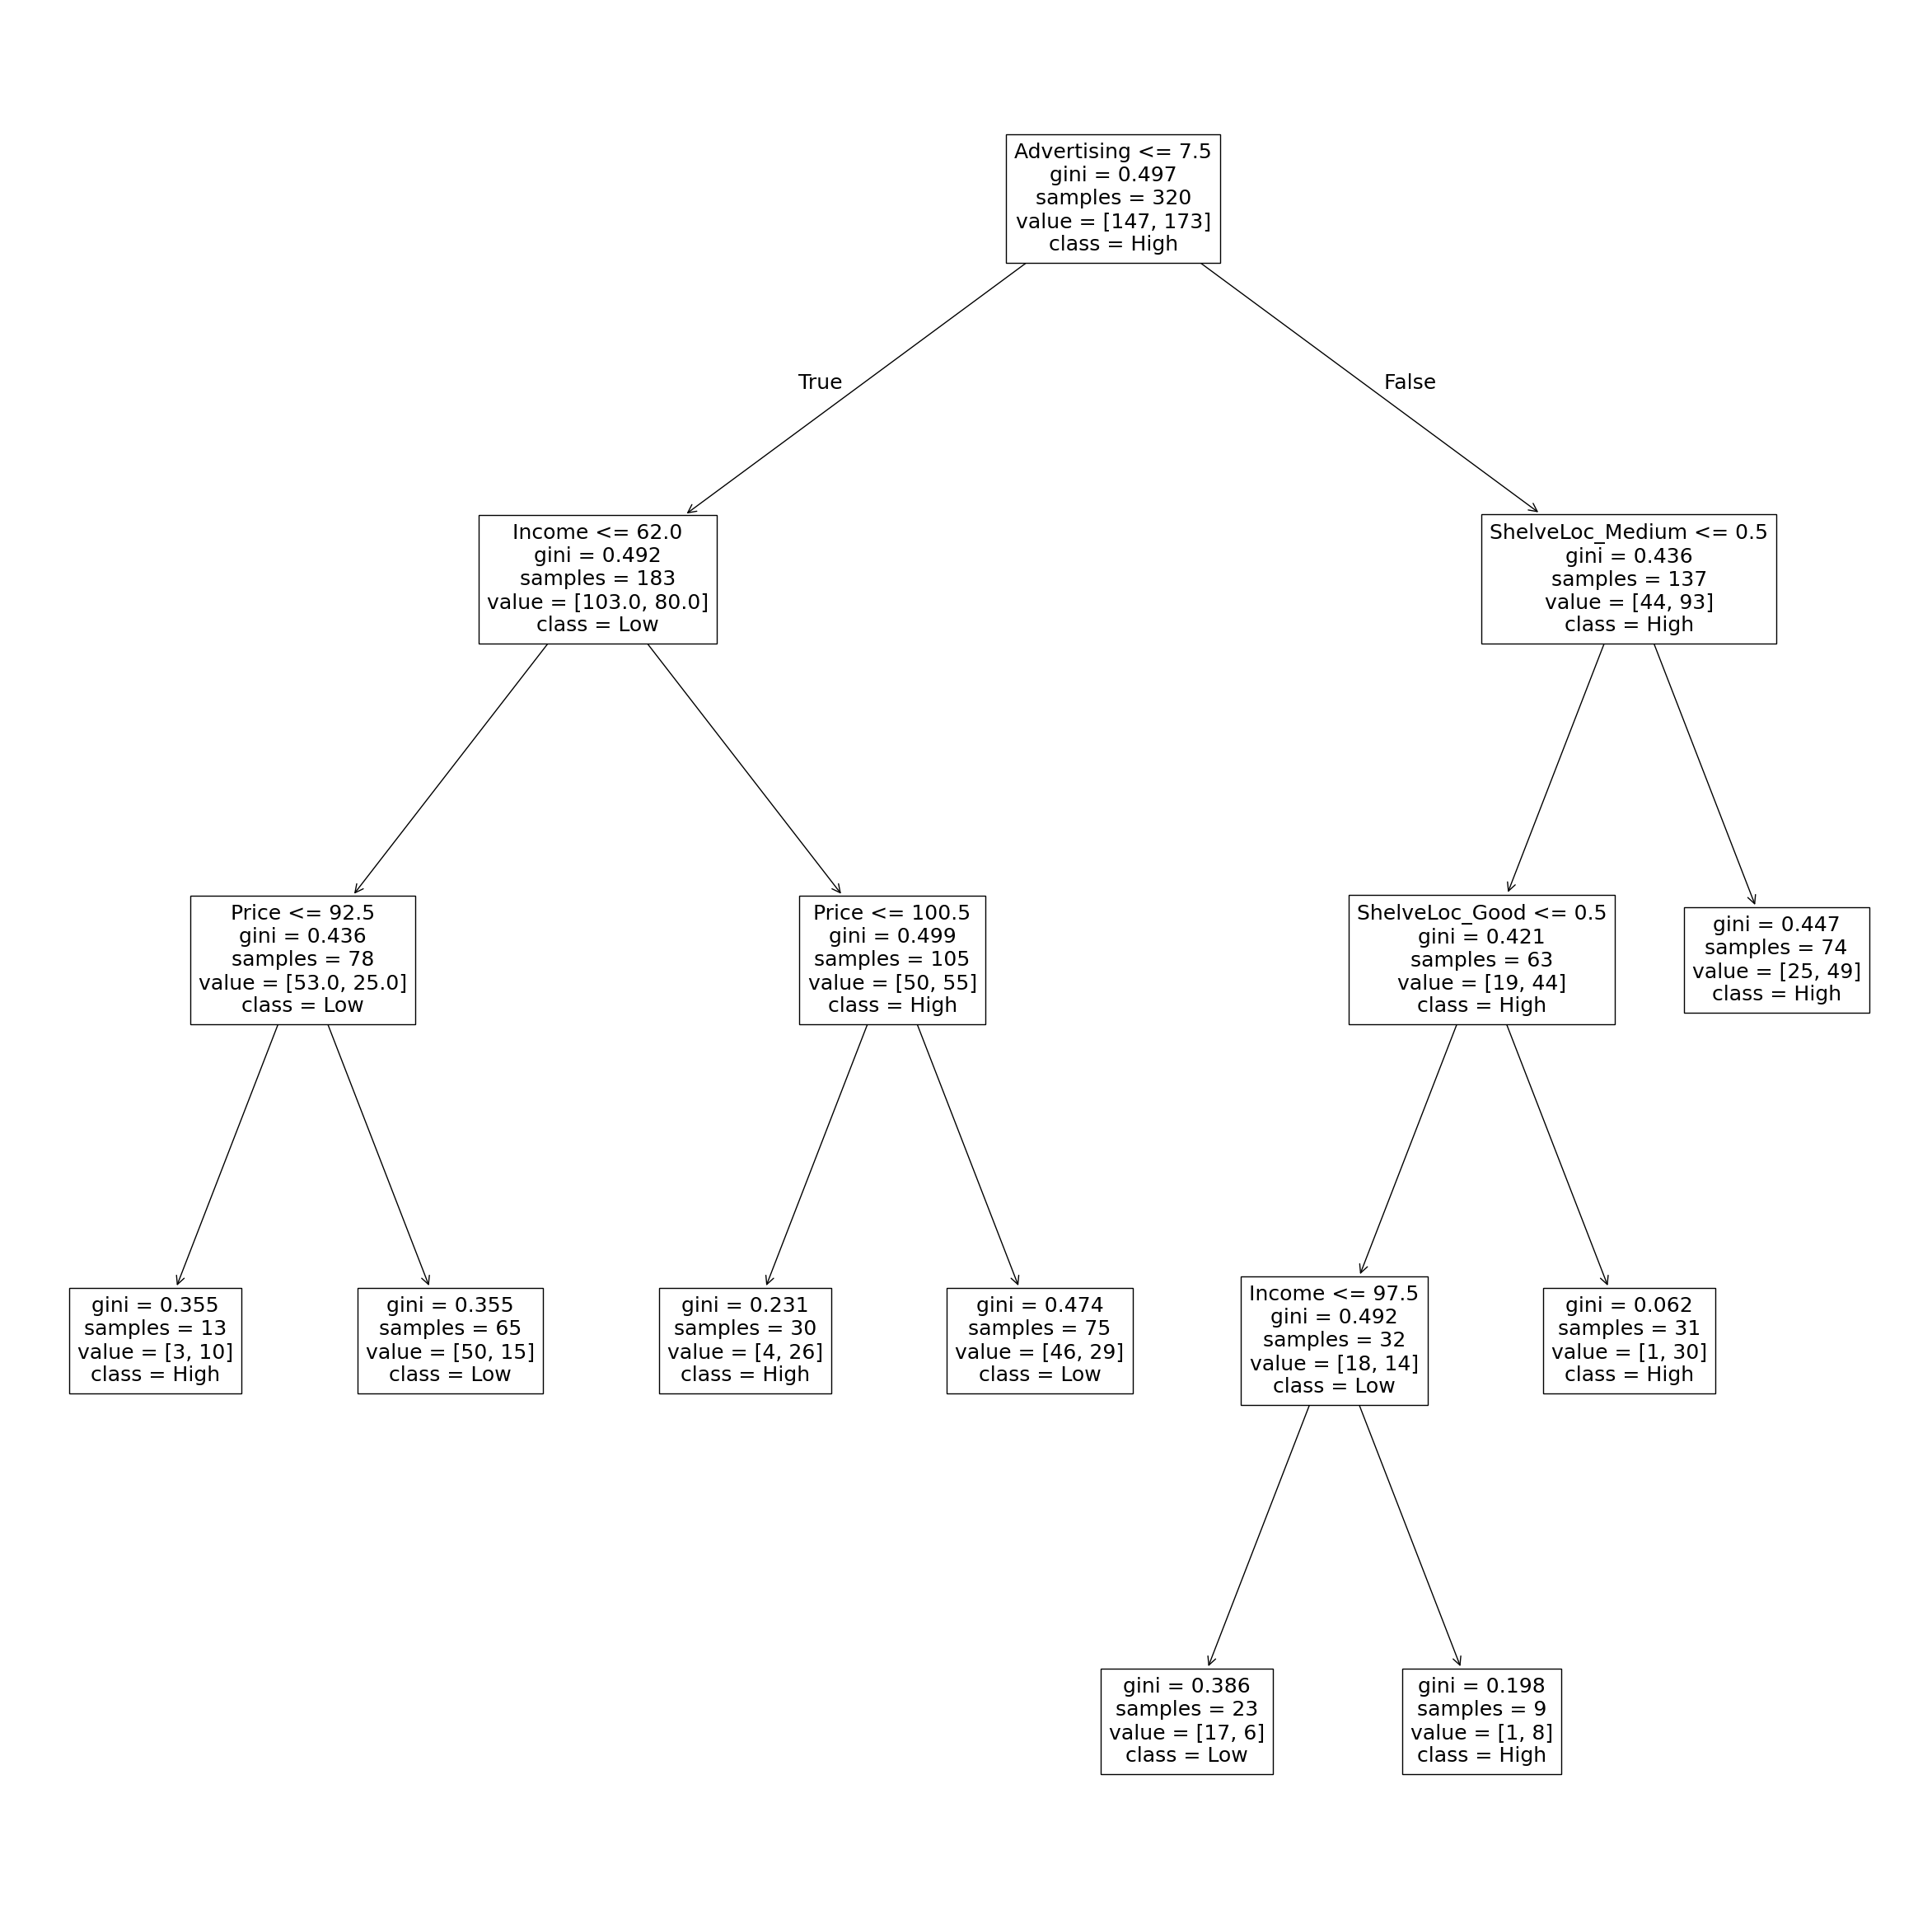

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))

plot_tree(tree, feature_names=X.columns,class_names=['Low','High'])
plt.show()

## Random Forest

A random forest an **ensemble** method based on a certain number of decisions tree. The number of trees, $B$, is a hyperparameter. 

To construct each tree in the random forest:
* (Bootstraping) Sample the same number of data records (i.e., rows; in the current example, 400 rows) from the original dataset, **with replacement**.

**Note**: Bootstraping is a widely used sampling technique to create multiple samples from one original sample.

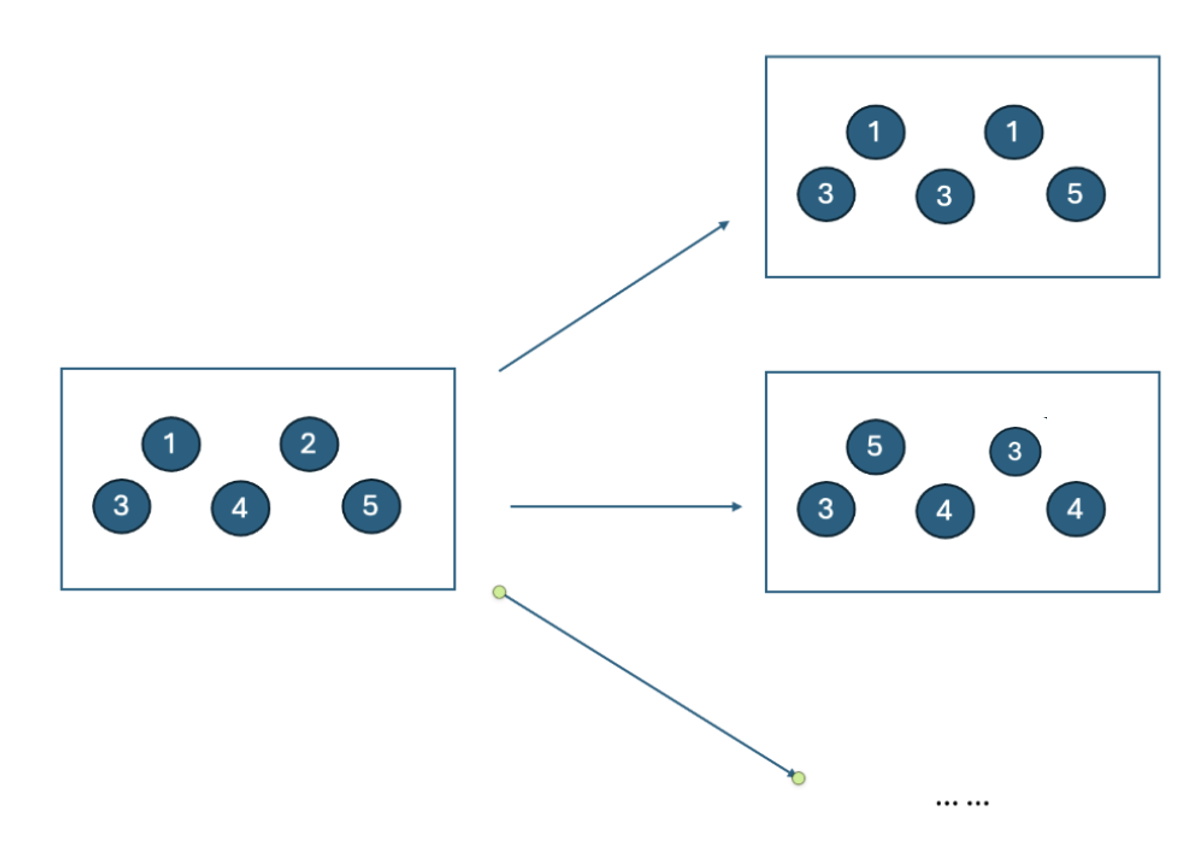</img>

In the above example, the ball labeled "2" is never sampled. Thus it is unseen by the model and can be used as a testing data point for evaluating the model's performance score. This is known as "out of bag scoring".

* For the bootstrapped sample, construct a decision tree.

* For a new data points not in the training dataset, make a prediction based on each of the $B$ decision trees.

* Average over all the $B$ trees to get the ensemble prediction.

We will need to import the `RandomForestClassifier()` method from the `ensemble` module in `sklearn`. 

In [68]:
from sklearn.ensemble import RandomForestClassifier as RFC

forest = RFC(
    criterion = 'gini',
    max_depth = 4,
    min_samples_split = 5, 
    min_samples_leaf = 3, 
    max_features = 'log2',
    ccp_alpha = 0.01,
    random_state = 18,
    
    n_estimators = 100,
    bootstrap = True,
    oob_score = False
)


In addition to the hyperparameters for the individual trees, we also have:
* `n_estimators`: total number of trees to construct 
    * default value is 100
* `bootstrap`: if set to False, each tree will be constructed based on the same dataset (the original dataset)
    * default value: True

* `oob_score`: Whether to use the 'out of bag' method to evaluate the performance scores
    * with the trees based on bootstrapped samples from the original dataset, there are usually data records never selected to construct any of the trees, i.e., unseen by the model during training. 
     * if `oob_score` is set to True, then we will evalute the performance score on those unselected data records; in other words, they serve as the test data.
     * default value is false

Now we can fit the random forest model.

In [69]:
forest.fit(X_train,y_train)

RandomForestClassifier(ccp_alpha=0.01, max_depth=4, max_features='log2',
                       min_samples_leaf=3, min_samples_split=5,
                       random_state=18)

Making predictions.

In [70]:
y_pred_rf = forest.predict(X_test)
y_prob_rf = forest.predict_proba(X_test)

Create the classification report and obtain the AUC score.

In [71]:
cr_rf = classification_report(y_test,y_pred_rf)
auc = roc_auc_score(y_test,y_prob_rf[:,1])

print(cr_rf)
print(f"AUC={auc}")

              precision    recall  f1-score   support

           0       0.73      0.81      0.77        37
           1       0.82      0.74      0.78        43

    accuracy                           0.78        80
   macro avg       0.78      0.78      0.77        80
weighted avg       0.78      0.78      0.78        80

AUC=0.8818353236957888


Perform cross-validation. Recall that:
* Define the strategy
* Specify the model, features (X), and target (y) in the positional arguments 
* `scoring=` specifies the performance score
* `cv=` specifies the cross validation strategy

In [72]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=18)

cv_scores = cross_val_score(forest,X,y,cv=skf,scoring='roc_auc')

In [73]:
print(f"AUC scores by 10-fold CV: {cv_scores}\n")
print(f"Average AUC by 10-fold CV = {cv_scores.mean()}")

AUC scores by 10-fold CV: [0.84848485 0.94444444 0.89393939 0.89141414 0.82828283 0.85606061
 0.8245614  0.77443609 0.93734336 0.9197995 ]

Average AUC by 10-fold CV = 0.8718766613503455


## Hyperparameter tuning

To select hyperparameters with good performance, we first define the space of hyperparameters to search over, in the form of a dictionary.

In [74]:
import numpy as np

param_grid={
    'criterion': ['gini','entropy'],
    'max_depth': range(2,20,2),
    'min_samples_split': [2,5,7,8,10],
    'min_samples_leaf': [2,4,6,8,10],
    'max_features': ['sqrt','log2'],
    'ccp_alpha': np.arange(0.01,0.2,0.01),
    'n_estimators': [5,15,25,50,75,100,125]
}

In the following, we will use `RandomizedSearchCV` to randomly select parameter combinations from the search space and evaluate the performance.

It has the following keyword arguments:
* `estimator=` specifies the model to perform the research with
* `param_distributions=` specifies the search space to use
* `n_iter=` is how many combinations we will try out
* `scoring` specifies the performance metric
* `n_jobs=` specifies the number of cpu cores to use for the search; -1 represents the use of all available cores.
* `random_state=` is for reproducibility

`RandomizedSearchCV` will randomly select `n_iter` combinations of the hyperparameter values defined in `param_grid`.  Define the search:

In [75]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator = forest,
    param_distributions = param_grid,
    n_iter = 50,
    scoring = 'roc_auc',
    n_jobs = -1,
    random_state=18
)

Conduct the search by `.fit`:

In [76]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(ccp_alpha=0.01, max_depth=4,
                                                    max_features='log2',
                                                    min_samples_leaf=3,
                                                    min_samples_split=5,
                                                    random_state=18),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 20, 2),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 5, 7, 8, 10],
                                        'n_estimators': [5, 15, 25, 50, 75, 100,
                                                         125]},
                   random_state=18, scoring='roc_auc')

Note that we used `.fit()` on the training dataset only. This means that during the fitting process:
* we did not make use of the test data
* `X_train` and `y_train` are further splitted into subsets (training and validation sets).

After fitting the RandomSearchCV, we may use `.best_params_` attribute of the search to find the best hyperparameters.

In [77]:
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'log2',
 'max_depth': 14,
 'criterion': 'entropy',
 'ccp_alpha': 0.02}

We may use `.best_estimator_` attribute to find the best model (i.e., the one with the best performing hyperparameters).

In [78]:
forest_best = random_search.best_estimator_

With the best model, we can evaluate the performance of the model on the test dataset.

In [79]:
y_pred = forest_best.predict(X_test)
y_prob = forest_best.predict_proba(X_test)

cr = classification_report(y_test,y_pred)
auc = roc_auc_score(y_test,y_prob[:,1])

In [80]:
print(cr)
print(f"AUC score of the tuned RF model is {auc}")

              precision    recall  f1-score   support

           0       0.79      0.84      0.82        37
           1       0.85      0.81      0.83        43

    accuracy                           0.82        80
   macro avg       0.82      0.83      0.82        80
weighted avg       0.83      0.82      0.83        80

AUC score of the tuned RF model is 0.9113764927718416
